# 20.1 Target Transformation: The F-Learner

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Implementation](#implementation)
4. [Numeric Demonstration](#numeric)
5. [Interview Appendix](#interview)
6. [References](#references)

---

## Learning Objectives

By the end of this notebook, you will:
- Understand the infeasibility problem in CATE estimation
- Derive the F-learner target transformation for binary treatments
- Implement plug-and-play CATE estimation with any ML model
- Recognize the variance cost of simplicity

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

set_notebook_style()
np.random.seed(123)

print("Imports loaded successfully")

Imports loaded successfully


---

## 1. Intuition <a name="intuition"></a>

### The CATE Estimation Challenge

In predictive modeling, we minimize outcome MSE:
$$E[(Y_i - \hat{Y}_i)^2]$$

For CATE estimation, we **want** to minimize treatment effect MSE:
$$E[(\tau(x)_i - \hat{\tau}(x)_i)^2]$$

**Problem**: We never observe $\tau(x)_i = Y_i(1) - Y_i(0)$. Only one potential outcome is realized.

### The Target Transformation Insight

**Key idea**: Transform the observable outcome into something that equals CATE *in expectation*.

For a 50/50 randomized experiment:
$$Y^*_i = 2 Y_i T_i - 2 Y_i (1-T_i)$$

- If treated (T=1): $Y^* = 2Y$
- If untreated (T=0): $Y^* = -2Y$

This seems bizarre - outcomes become negative for control units. But remarkably:
$$E[Y^*_i | X_i = x] = \tau(x)_i$$

### Why This Works

The transformation "borrows" information across treatment groups:
- Treated units contribute information about $Y(1)$
- Control units contribute information about $Y(0)$
- Proper weighting combines them into unbiased CATE estimate

---

## 2. Formal Treatment <a name="formal"></a>

### General Target Transformation (Binary Treatment)

For non-equal propensity:
$$Y^*_i = Y_i \cdot \frac{T_i - e(X_i)}{e(X_i)(1-e(X_i))}$$

where $e(X_i) = P(T_i = 1 | X_i)$ is the propensity score.

### Proof: $E[Y^* | X] = \tau(X)$

**Setup**: Under conditional independence $(Y(0), Y(1)) \perp T | X$.

**Step 1**: Decompose by treatment status:
$$Y_i = Y_i(1) T_i + Y_i(0)(1-T_i)$$

**Step 2**: Expand the transformation:
$$E[Y^*_i | X=x] = E\left[Y_i \cdot \frac{T_i - e(x)}{e(x)(1-e(x))} \Big| X=x\right]$$

**Step 3**: Separate treated and control terms:
$$= E\left[Y_i(1) \cdot \frac{T_i(1-e(x))}{e(x)(1-e(x))} \Big| X=x\right] - E\left[Y_i(0) \cdot \frac{(1-T_i)e(x)}{e(x)(1-e(x))} \Big| X=x\right]$$

**Step 4**: Apply conditional independence:
$$= \frac{E[Y_i(1)|X=x] \cdot e(x)}{e(x)} - \frac{E[Y_i(0)|X=x] \cdot (1-e(x))}{(1-e(x))}$$

**Step 5**: Simplify:
$$= E[Y_i(1)|X=x] - E[Y_i(0)|X=x] = \tau(x)$$

### Special Case: RCT with Constant Propensity

If $e(X) = p$ for all $X$ (randomized experiment):
$$Y^*_i = Y_i \cdot \frac{T_i - p}{p(1-p)}$$

For 50/50 split ($p = 0.5$):
$$Y^*_i = Y_i \cdot \frac{T_i - 0.5}{0.25} = 4Y_i(T_i - 0.5) = 2Y_i T_i - 2Y_i(1-T_i)$$

---

## 3. Implementation <a name="implementation"></a>

### F-Learner Algorithm

1. **Estimate propensity** (if not known): $\hat{e}(X)$
2. **Transform target**: $Y^*_i = Y_i \cdot \frac{T_i - \hat{e}(X_i)}{\hat{e}(X_i)(1-\hat{e}(X_i))}$
3. **Fit any ML model**: $\hat{\tau}(X) = M(X)$ to predict $Y^*$
4. **Predict CATE**: Model outputs are CATE estimates

In [2]:
def f_learner_transform(Y: np.ndarray, T: np.ndarray, ps: float | np.ndarray) -> np.ndarray:
    """
    F-learner target transformation for binary treatment.
    
    Parameters
    ----------
    Y : array-like
        Outcome variable
    T : array-like
        Binary treatment indicator (0 or 1)
    ps : float or array-like
        Propensity score(s) P(T=1|X)
        
    Returns
    -------
    Y_star : array
        Transformed target where E[Y*|X] = CATE(X)
    """
    return Y * (T - ps) / (ps * (1 - ps))


class FLearner:
    """
    F-Learner: Plug-and-play CATE estimator via target transformation.
    
    Named after the "Feature" or "Fundamental" learner - uses simple
    target transformation to convert any regression model into a CATE estimator.
    """
    
    def __init__(self, base_model=None):
        """
        Parameters
        ----------
        base_model : sklearn-compatible regressor, optional
            Default: LGBMRegressor with conservative hyperparameters
        """
        if base_model is None:
            base_model = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5, verbose=-1)
        self.model = base_model
        self.ps_ = None
        
    def fit(self, X, Y, T, ps=None):
        """
        Fit F-learner.
        
        Parameters
        ----------
        X : array-like (n, p)
            Covariates
        Y : array-like (n,)
            Outcome
        T : array-like (n,)
            Binary treatment
        ps : float or array-like, optional
            Propensity score. If None, uses marginal P(T=1).
        """
        self.ps_ = ps if ps is not None else T.mean()
        Y_star = f_learner_transform(Y, T, self.ps_)
        self.model.fit(X, Y_star)
        return self
    
    def predict(self, X):
        """Predict CATE for new units."""
        return self.model.predict(X)

print("F-Learner implementation ready")

F-Learner implementation ready


---

## 4. Numeric Demonstration <a name="numeric"></a>

### Investment Email Experiment

An investment firm sends financial education emails to increase customer investments.
- **Treatment**: Email sent (binary)
- **Outcome**: Converted (invested)
- **Goal**: Find which customers respond best to emails (personalization)

In [3]:
# Load investment email data
email = load_facure_data('invest_email_rnd.csv')
print(f"Dataset shape: {email.shape}")
print(f"\nColumns: {email.columns.tolist()}")
email.head()

Dataset shape: (15000, 8)

Columns: ['age', 'income', 'insurance', 'invested', 'em1', 'em2', 'em3', 'converted']


,age,income,insurance,invested,em1,em2,em3,converted
0,44.1000,5483.8000,6155.2900,14294.8100,0,1,1,0
1,39.8000,2737.9200,50069.4000,7468.1500,1,0,0,0
2,49.0000,2712.5100,5707.0800,5095.6500,1,0,1,1
3,39.7000,2326.3700,15657.9700,6345.2000,1,1,1,0
4,35.3000,2787.2600,27074.4400,14114.8600,1,1,1,0


In [4]:
# Define variables
y = "converted"
T = "em1"  # Email 1 treatment
X = ["age", "income", "insurance", "invested"]

# Train/test split
np.random.seed(123)
train, test = train_test_split(email, test_size=0.4)
print(f"Train: {train.shape[0]}, Test: {test.shape[0]}")

# Treatment probability (known from randomization)
ps = train[T].mean()
print(f"Propensity score (treatment probability): {ps:.3f}")

Train: 9000, Test: 6000
Propensity score (treatment probability): 0.505


In [5]:
# Apply target transformation
Y_star_train = f_learner_transform(train[y].values, train[T].values, ps)

# Examine transformation
print("Target Transformation Statistics:")
print(f"  Original Y range: [{train[y].min():.2f}, {train[y].max():.2f}]")
print(f"  Transformed Y* range: [{Y_star_train.min():.2f}, {Y_star_train.max():.2f}]")
print(f"  Y* mean (should ≈ ATE): {Y_star_train.mean():.4f}")

# Compare to simple difference in means
simple_ate = train[train[T]==1][y].mean() - train[train[T]==0][y].mean()
print(f"  Simple ATE estimate: {simple_ate:.4f}")

Target Transformation Statistics:
  Original Y range: [0.00, 1.00]
  Transformed Y* range: [-2.02, 1.98]
  Y* mean (should ≈ ATE): 0.0710
  Simple ATE estimate: 0.0710


In [6]:
# Fit F-learner
f_learner = FLearner()
f_learner.fit(train[X], train[y].values, train[T].values, ps=ps)

# Predict CATE on test set
test_pred = test.assign(cate=f_learner.predict(test[X]))

# Show CATE variation
print("CATE Predictions:")
print(f"  Mean: {test_pred['cate'].mean():.4f}")
print(f"  Std:  {test_pred['cate'].std():.4f}")
print(f"  Range: [{test_pred['cate'].min():.4f}, {test_pred['cate'].max():.4f}]")

test_pred[['age', 'income', 'em1', 'converted', 'cate']].head(10)

CATE Predictions:
  Mean: 0.0735
  Std:  0.0660
  Range: [-0.1412, 0.3857]


,age,income,em1,converted,cate
6958,40.9000,4486.1400,0,0,0.1057
7534,42.6000,6386.1900,0,0,0.1219
2975,47.6000,1900.2600,0,0,0.0342
3903,41.0000,5802.1900,1,1,0.0468
8437,49.1000,2202.9600,1,0,-0.0091
6812,40.3000,1757.3700,1,0,0.1054
1567,42.8000,1362.2800,1,0,0.0485
14680,45.4000,7250.2300,0,0,0.1694
10189,40.9000,852.5800,1,0,0.0462
14380,33.6000,2503.4400,1,0,0.0689


In [7]:
# Define evaluation functions (from Ch 19)
def sensitivity(data, y, t):
    """Estimate treatment effect (elasticity) via OLS coefficient."""
    t_bar = data[t].mean()
    y_bar = data[y].mean()
    cov = np.sum((data[t] - t_bar) * (data[y] - y_bar))
    var = np.sum((data[t] - t_bar) ** 2)
    return cov / var if var > 0 else 0

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    """Compute cumulative gain curve."""
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) 
                     for rows in n_rows])

print("Evaluation functions defined")

Evaluation functions defined


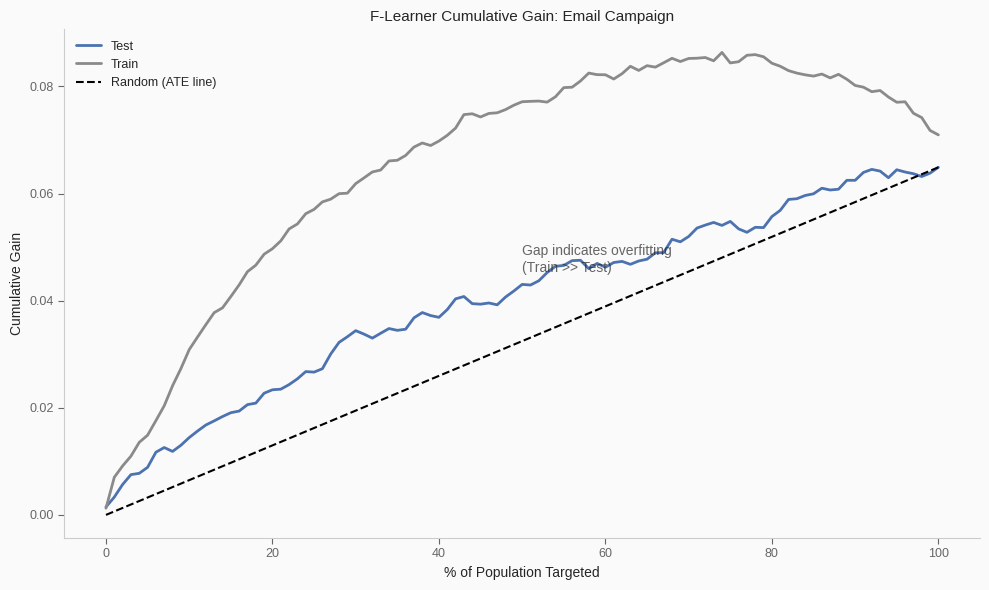


Baseline ATE: 0.0649


In [8]:
# Evaluate F-learner with cumulative gain curves
gain_curve_test = cumulative_gain(test_pred, "cate", y="converted", t="em1")

train_pred = train.assign(cate=f_learner.predict(train[X]))
gain_curve_train = cumulative_gain(train_pred, "cate", y="converted", t="em1")

# Baseline ATE
baseline_ate = sensitivity(test, "converted", "em1")

# Plot
fig, ax = create_tufte_figure(figsize=(10, 6))

# Use separate x axes for each curve to handle different lengths
x_axis_test = np.linspace(0, 100, len(gain_curve_test))
x_axis_train = np.linspace(0, 100, len(gain_curve_train))

ax.plot(x_axis_test, gain_curve_test, color=COLORS['blue'], linewidth=2, label='Test')
ax.plot(x_axis_train, gain_curve_train, color=COLORS['gray'], linewidth=2, label='Train')
ax.plot([0, 100], [0, baseline_ate], linestyle='--', color='black', 
        linewidth=1.5, label='Random (ATE line)')

ax.set_xlabel('% of Population Targeted')
ax.set_ylabel('Cumulative Gain')
ax.set_title('F-Learner Cumulative Gain: Email Campaign')
ax.legend(loc='upper left')

# Add annotation
ax.text(50, baseline_ate * 0.7, 'Gap indicates overfitting\n(Train >> Test)', 
        fontsize=10, alpha=0.7)

plt.tight_layout()
plt.show()

print(f"\nBaseline ATE: {baseline_ate:.4f}")

### Interpretation

The F-learner shows:
1. **Better than random** on test set (curve above diagonal)
2. **Significant overfitting** (train >> test performance)
3. **High variance** is the cost of the simple transformation

The transformed target $Y^*$ is a noisy estimate of individual treatment effect - this variance propagates to CATE predictions.

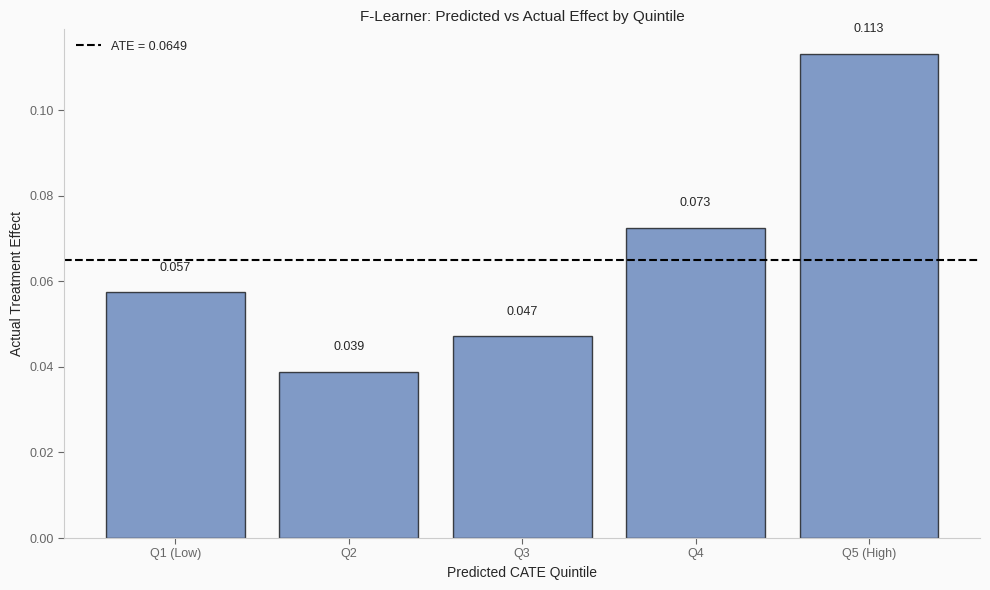


Actual effect by predicted CATE quintile:
cate_quintile
Q1 (Low)    0.0574
Q2          0.0389
Q3          0.0472
Q4          0.0726
Q5 (High)   0.1133
dtype: float64


In [9]:
# Examine heterogeneity by CATE quintile
test_pred['cate_quintile'] = pd.qcut(test_pred['cate'], q=5, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4', 'Q5 (High)'])

# Actual effect by quintile
quintile_effects = test_pred.groupby('cate_quintile', observed=True).apply(
    lambda df: sensitivity(df, 'converted', 'em1'),
    include_groups=False
)

fig, ax = create_tufte_figure(figsize=(10, 6))

bars = ax.bar(range(5), quintile_effects.values, color=COLORS['blue'], alpha=0.7, edgecolor='black')
ax.axhline(y=baseline_ate, color='black', linestyle='--', label=f'ATE = {baseline_ate:.4f}')

ax.set_xticks(range(5))
ax.set_xticklabels(quintile_effects.index)
ax.set_xlabel('Predicted CATE Quintile')
ax.set_ylabel('Actual Treatment Effect')
ax.set_title('F-Learner: Predicted vs Actual Effect by Quintile')
ax.legend()

# Add values on bars
for i, (bar, val) in enumerate(zip(bars, quintile_effects.values)):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.005, f'{val:.3f}', 
            ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nActual effect by predicted CATE quintile:")
print(quintile_effects)

### Key Observations

1. **Monotonicity**: Higher predicted CATE → higher actual effect (model is calibrated)
2. **Effect range**: Q5 (high CATE) has meaningfully higher effect than Q1
3. **Targeting value**: By targeting Q4-Q5, we can get above-average returns

---

## 5. Interview Appendix <a name="interview"></a>

### Q1: What is the F-learner and why is it called "plug-and-play"?

<details>
<summary>Solution</summary>

**F-Learner** (Feature/Fundamental learner) transforms the outcome variable so any regression model can estimate CATE:

$$Y^* = Y \cdot \frac{T - e(X)}{e(X)(1-e(X))}$$

**Plug-and-play** because:
1. Transform target once
2. Use any ML model (XGBoost, RF, NN, etc.) to predict $Y^*$
3. Model predictions = CATE estimates

**Pros**: Simple, any model works, no custom loss function  
**Cons**: High variance, only binary treatment, prone to overfitting

</details>

### Q2: Why does the F-learner have high variance?

<details>
<summary>Solution</summary>

The transformed target $Y^*$ is **individually noisy** even though it's unbiased in expectation:

$$Var(Y^*) = Var\left(Y \cdot \frac{T - e(X)}{e(X)(1-e(X))}\right)$$

Key issues:
1. **Denominator shrinks** when $e(X) \approx 0$ or $e(X) \approx 1$ → extreme weights
2. **Sign flip**: Treated get positive, control get negative transformed outcomes
3. **No smoothing**: Each unit's $Y^*$ is a noisy individual CATE estimate

This variance transfers directly to CATE predictions, causing overfitting.

**Mitigation**:
- Large sample sizes (variance decreases with $n$)
- Regularized base models
- Weight trimming (cap extreme propensities)

</details>

### Q3: How does the F-learner relate to IPTW?

<details>
<summary>Solution</summary>

Both use propensity-based weighting:

**IPTW** for ATE:
$$\hat{\tau}_{IPTW} = \frac{1}{n}\sum_i \frac{T_i Y_i}{e(X_i)} - \frac{1}{n}\sum_i \frac{(1-T_i)Y_i}{1-e(X_i)}$$

**F-learner** target:
$$Y^* = Y \cdot \frac{T - e(X)}{e(X)(1-e(X))}$$

Connection:
- F-learner is like "per-unit IPTW" that estimates individual effects
- $E[Y^*] = $ ATE (just like IPTW)
- $E[Y^*|X] = $ CATE (F-learner predicts conditional version)

Both suffer from propensity extremity issues.

</details>

---

## 6. References <a name="references"></a>

1. **Athey, S. & Imbens, G.W.** (2016). *Machine Learning Methods for Estimating Heterogeneous Causal Effects*. Draft.

2. **Gutierrez, P. & Gérardy, J-Y.** (2017). *Causal Inference and Uplift Modeling: A Review of the Literature*. JMLR Workshop Proceedings.

3. **Künzel, S.R. et al.** (2019). *Metalearners for Estimating Heterogeneous Treatment Effects using Machine Learning*. PNAS.

4. **Facure, M.** (2022). *Causal Inference for the Brave and True*, Chapter 20.